In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from main import demonstration_items, run_tests, demonstration_test, make_polys_objects
from pathlib import Path

path_items = Path("data/items")
path_tests = Path("data/test")

data\items\img01.png


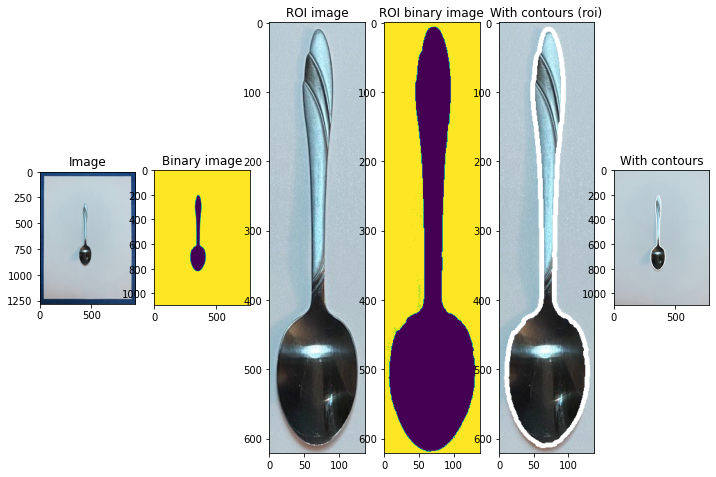

data\items\img02.png


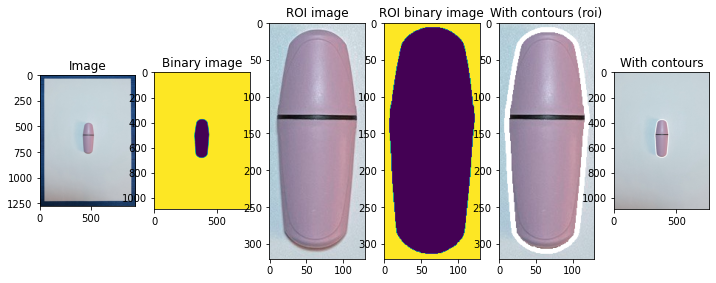

data\items\img03.png


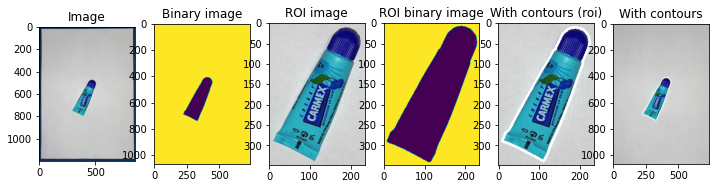

data\items\img04.png


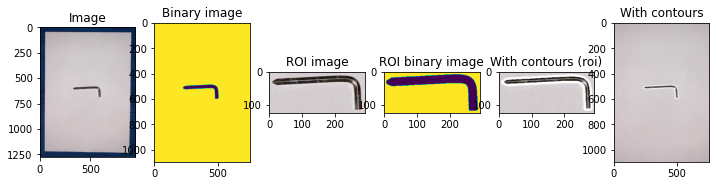

data\items\img05.png


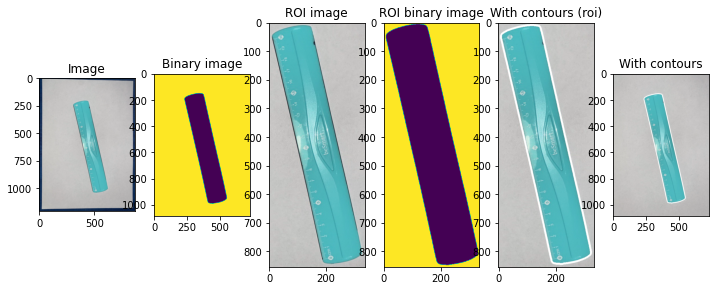

data\items\img06.png


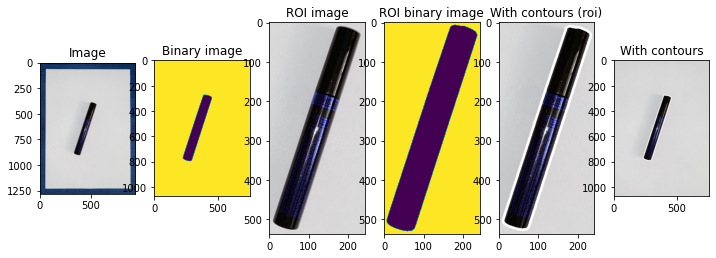

data\items\img07.png


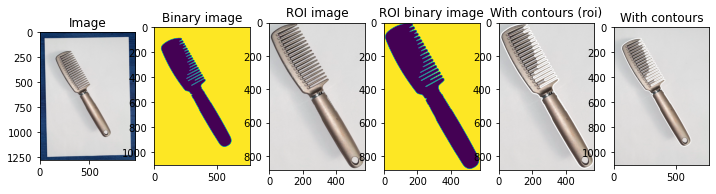

data\items\img08.png


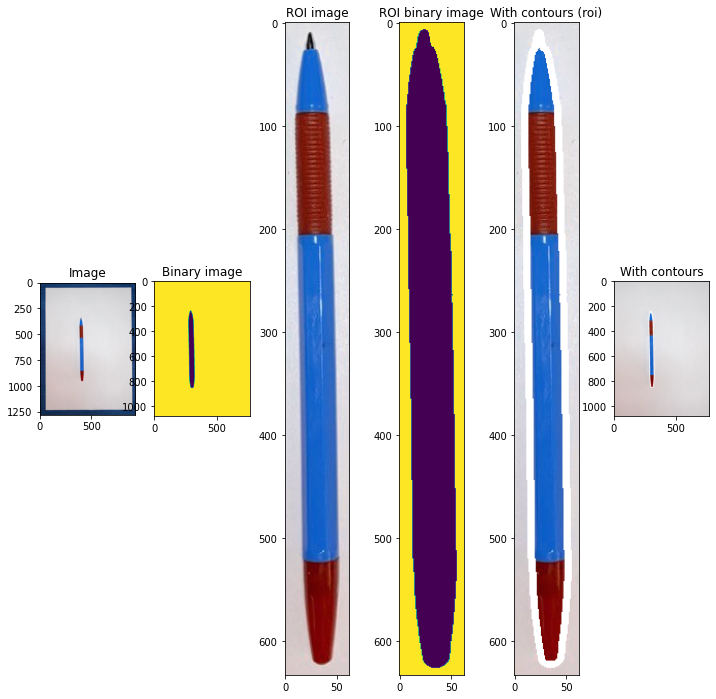

data\items\img09.png


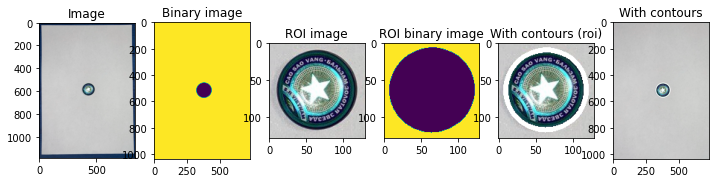

data\items\img10.png


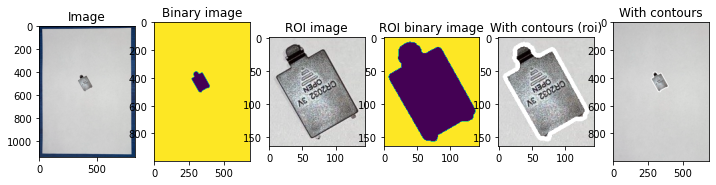

In [3]:
demonstration_items(path_items)

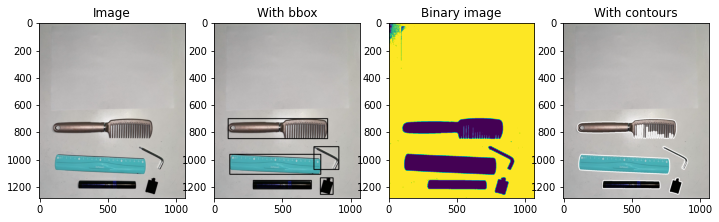

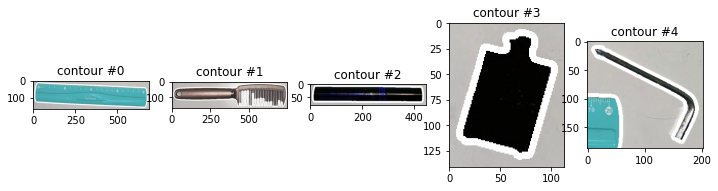

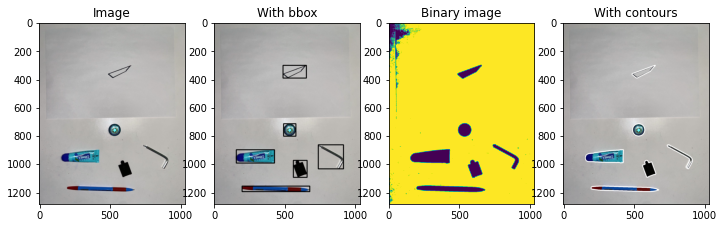

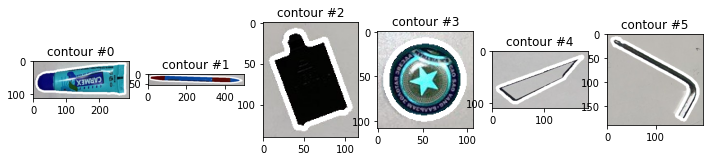

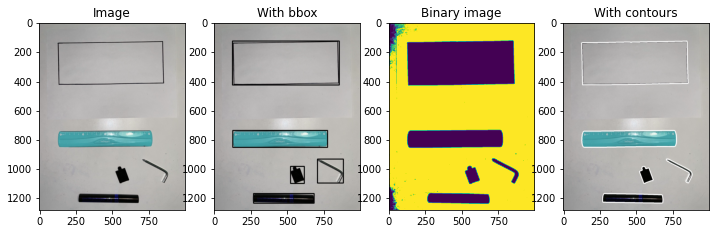

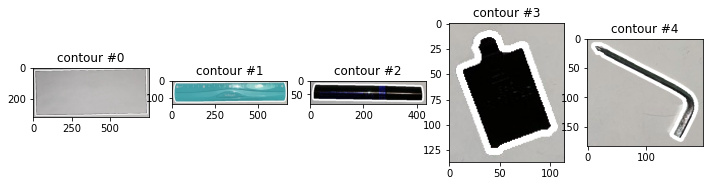

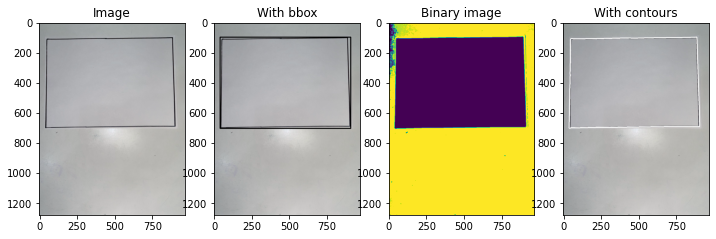

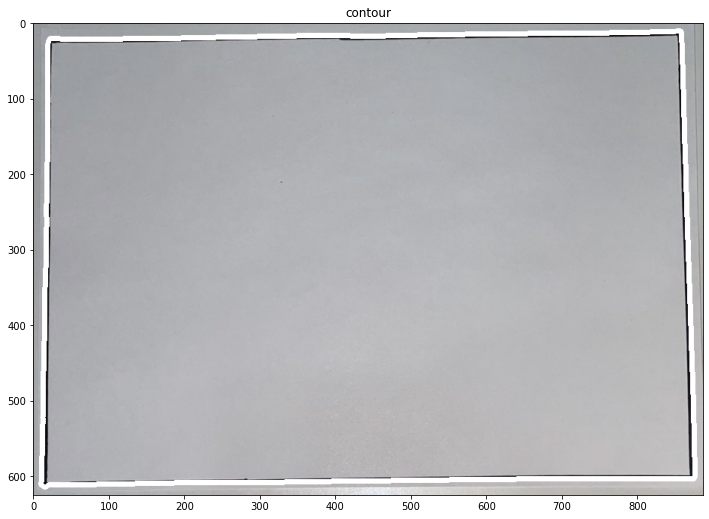

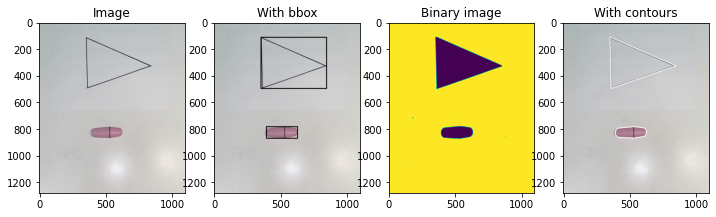

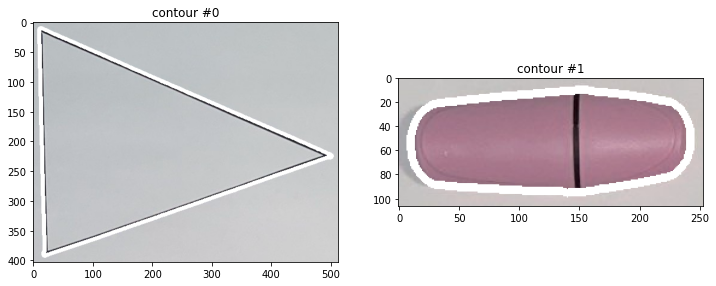

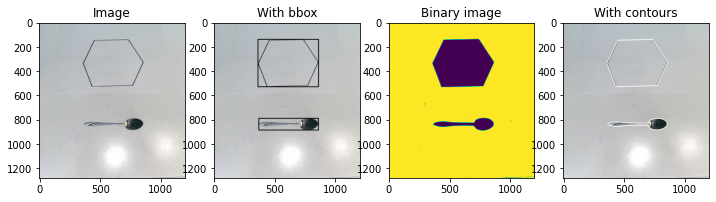

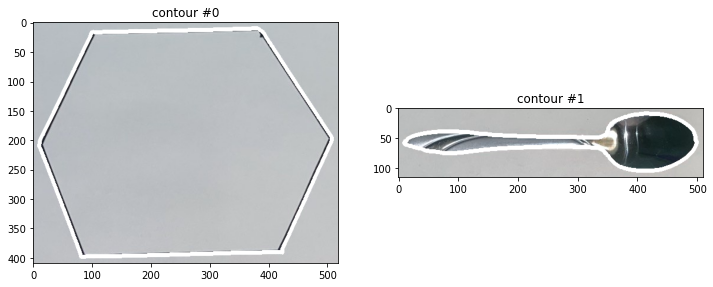

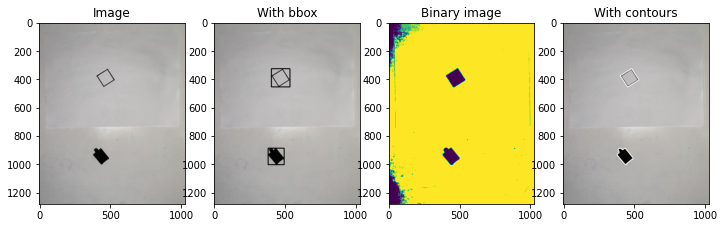

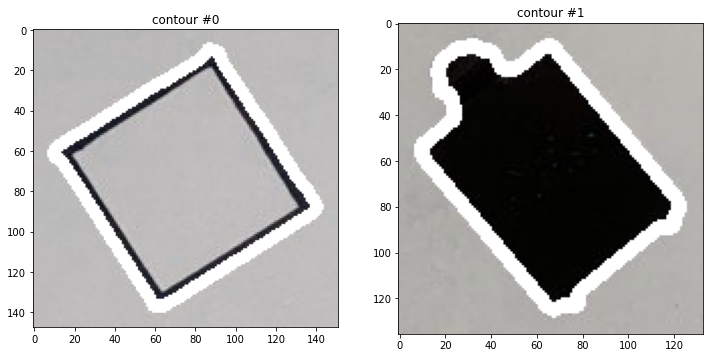

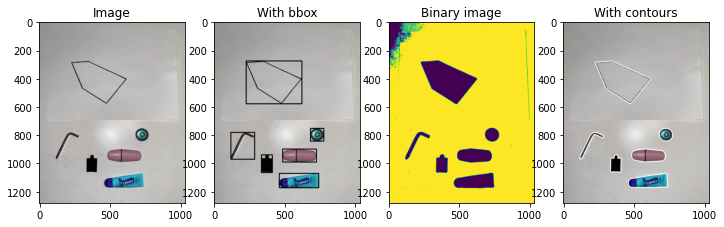

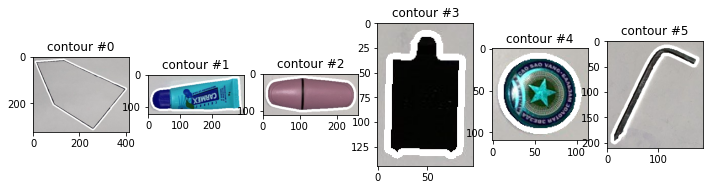

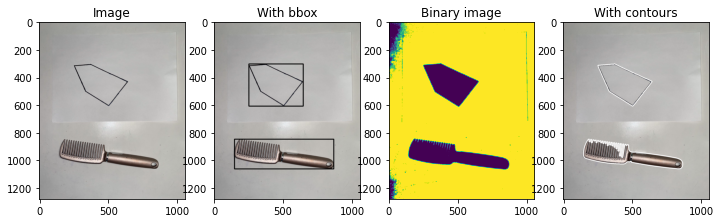

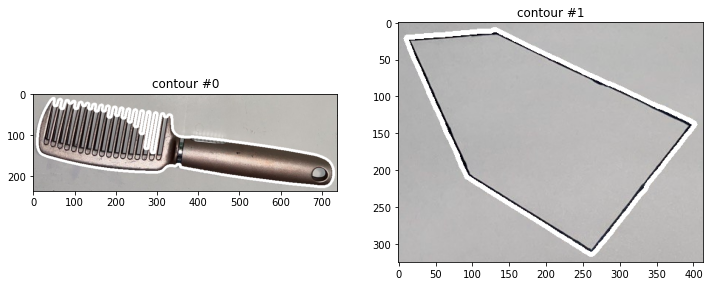

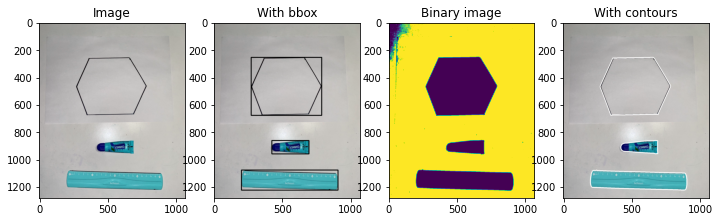

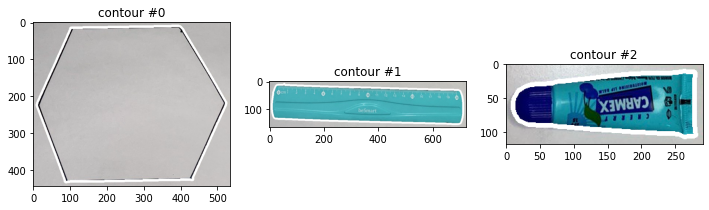

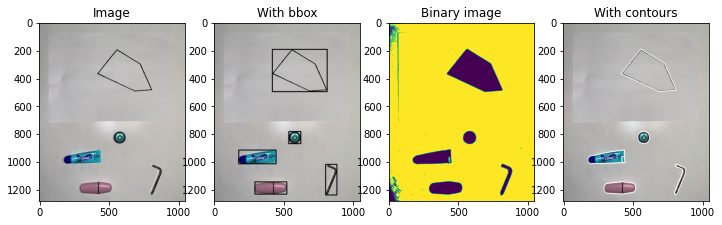

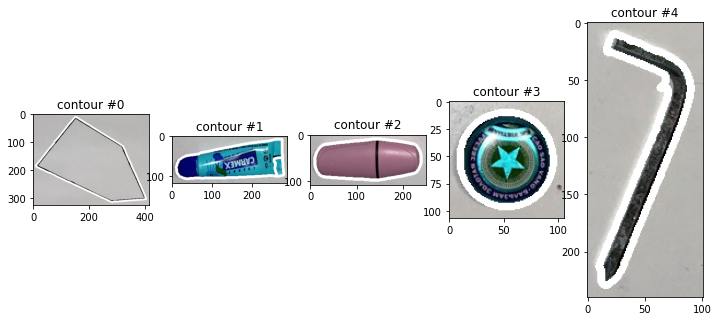

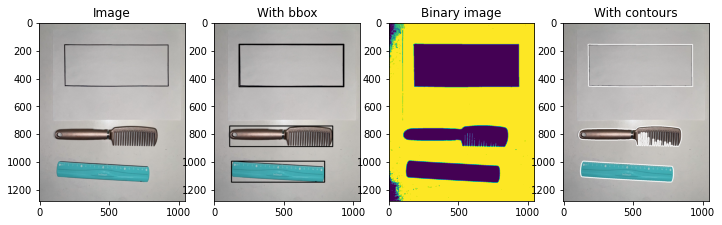

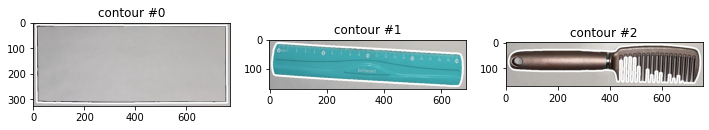

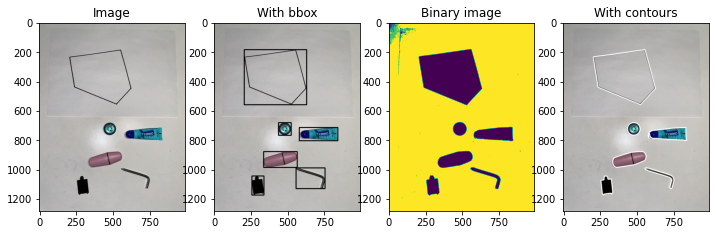

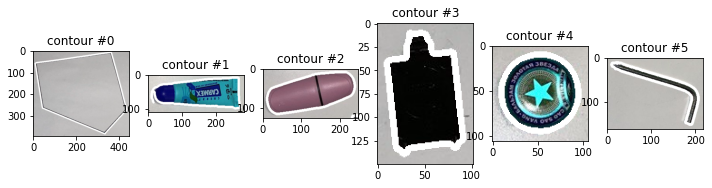

In [4]:
demonstration_test(path_tests)

In [6]:
import pandas as pd 
result_area, result_diameter = run_tests(path_tests)

data = pd.read_csv('data/label.csv', sep=r'\s*,\s*', header=0, engine='python')
labels = data['label'].tolist()
label = [str(label) for label in labels]
result_diameter = [str(diameter_obj) for diameter_obj in result_diameter]
count_area = 0
count_diameter = 0

for i in range(len(label)):
    if label[i] == result_area[i] and result_area[i] == "False":
        count_area += 1
    if label[i] == result_diameter[i] and result_diameter[i] == "False":
        count_diameter += 1

print("  label ", label)
print("  area  ", result_area)
print("diameter", result_diameter)
print("Всего фотографий, предметы на которых не поместятся во многоугольник(исключение - первое изображение) -", count_area)
print("Всего фотографий, предметы на которых не поместятся по ширине/высоте -", count_diameter)

  label  ['False', 'False', 'True', 'False', 'True', 'True', 'False', 'False', 'False', 'False', 'True', 'True', 'True']
  area   ['False', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True']
diameter ['True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'False', 'True', 'True', 'True']
Всего фотографий, предметы на которых не поместятся во многоугольник(исключение - первое изображение) - 3
Всего фотографий, предметы на которых не поместятся по ширине/высоте - 3


Можно заметить, что с помощью проверок площадей и габаритов предметов удалось найти те изображения, которые точно возвращают false, как это и требуется (исключение -  случай с отсутствием многоугольника на изображении, данная проверка еще не добавлена)

C:\Users\nelli\CLionProjects\intelligent-placer\main.py:127: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  new_shape = so.cascaded_union([objs for objs in objects])


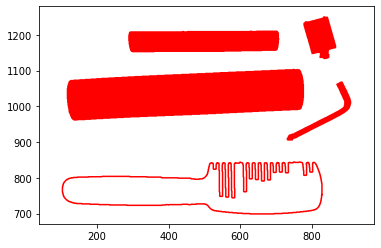

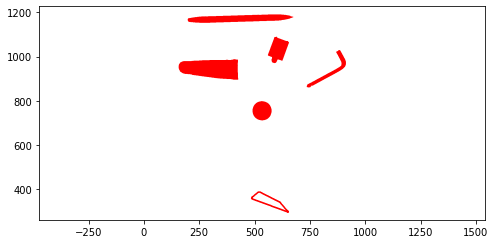

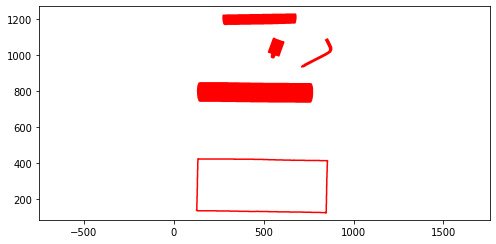

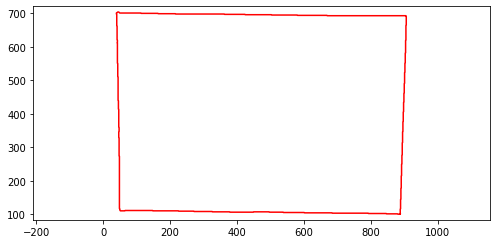

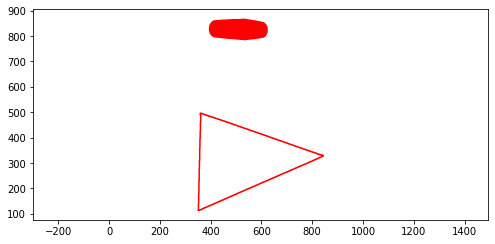

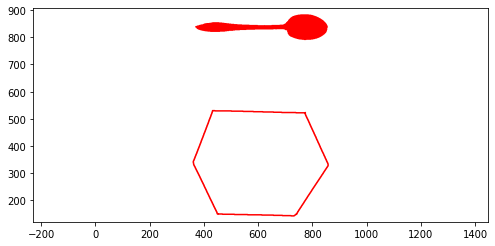

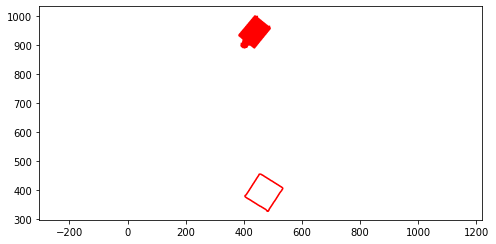

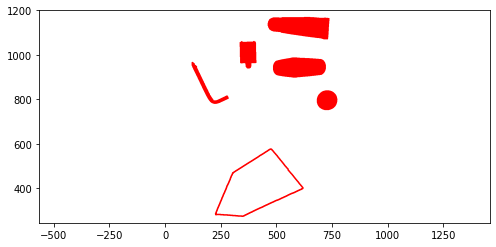

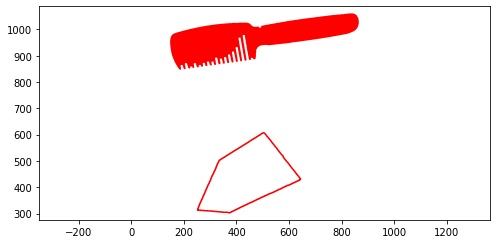

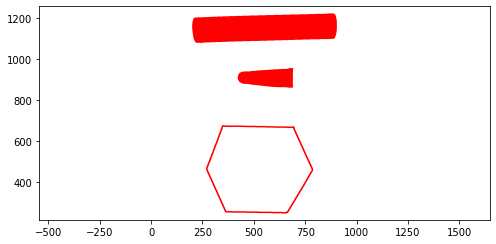

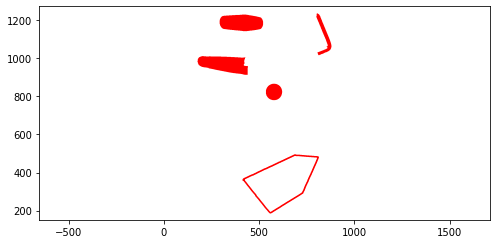

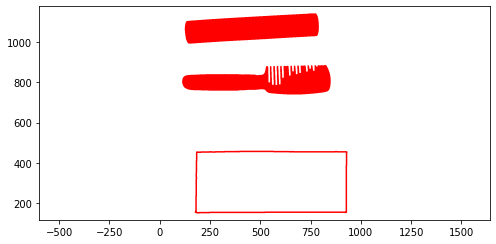

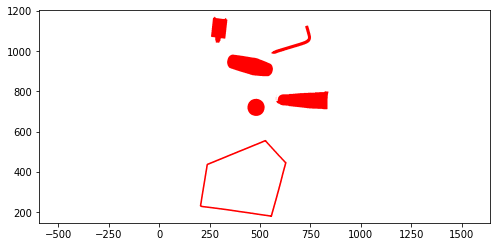

In [7]:
make_polys_objects(path_tests)

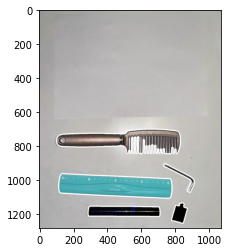

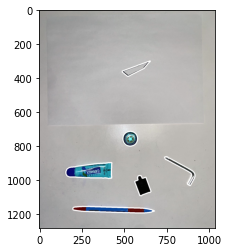

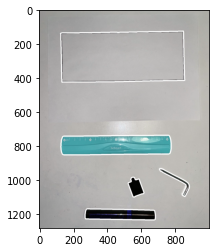

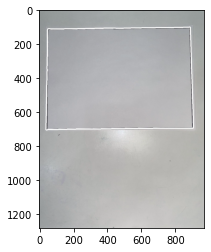

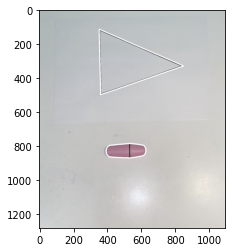

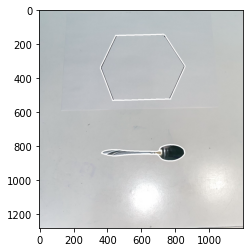

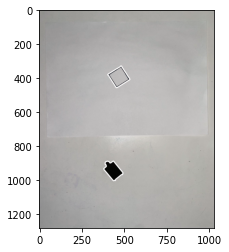

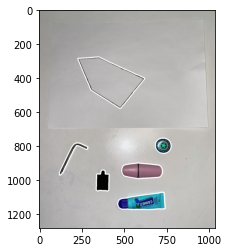

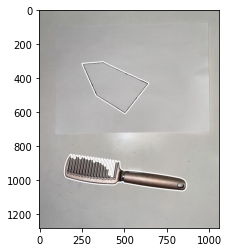

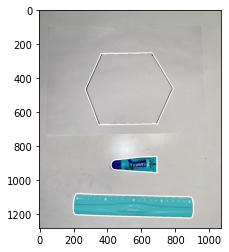

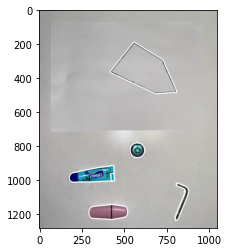

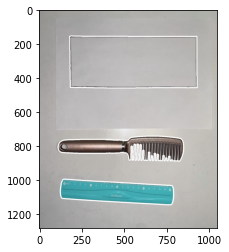

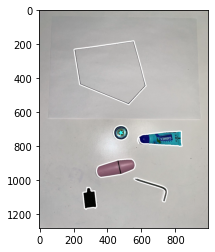

In [10]:
import cv2

MIN_AREA = 100  # площадь меньше, которой обнаруженные маски будут считаться дефектными


def get_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 10, 100)
    return edged

from main import demonstration_items, run_tests, demonstration_test, make_polys_objects
from pathlib import Path

path_tests = Path("data/test")

def draw_contours_mask(binary, contours):
    # зададим список для найденных масок
    masks_coords = []
    # а также для контуров
    cnts = []
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # обнаруженные небольшие дефекты исключаем, задав минимальную площадь
        if area > MIN_AREA:
            cnts.append(cnt)
            peri = cv2.arcLength(cnt, True)
            # аппроксимируем найденный контур многоугольником
            approx = cv2.approxPolyDP(cnt, 0.000001 * peri, True)
            masks_coords.append(approx)
            cv2.drawContours(binary, [approx], -1, (0, 0, 0), 5)
            cv2.fillPoly(binary, pts=[approx], color=(0, 0, 0))
    return cnts, masks_coords, binary


def get_fill_masks(image):
    # ищем границы
    closed = get_edges(image)
    # находим контуры листа
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts, masks_coords, binary = draw_contours_mask(closed, contours)
    return image, binary, masks_coords, cnts

from detection import get_fill_masks
import cv2
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import shapely.ops as so

FORMAT = "*"
RGB_WHITE = (255, 255, 255)
RGB_BLACK = (0, 0, 0)
THICKNESS = 5
CONTOUR_IDX = -1
BORDER = 10


# получим все изображения необходимого формата из папки 
def get_paths(path):
    paths = []
    for p_test in path.glob(FORMAT):
        paths.append(p_test)
    return paths

def demonstration_test(path_tests):
    paths = get_paths(path_tests)
    for p in paths:
        # загрузка изображения
        image = cv2.imread(str(p))
        img, binary, polys, _ = get_fill_masks(image.copy())
        contours = img.copy()
        cv2.drawContours(contours, polys, CONTOUR_IDX, RGB_WHITE, THICKNESS)

        plt.imshow(contours)
        plt.show()


demonstration_test(path_tests)


# если рассматривать данный подход, то тогда сами маски для входных данных будут искаться с помощью обученной готовой модели u2net